In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 1.0/101.7 MB 13.2 MB/s eta 0:00:08
   ---- ----------------------------------- 11.8/101.7 MB 43.5 MB/s eta 0:00:03
   ---------- ----------------------------- 27.5/101.7 MB 58.0 MB/s eta 0:00:02
   ---------------- ----------------------- 42.5/101.7 MB 62.0 MB/s eta 0:00:01
   ---------------------- ----------------- 57.1/101.7 MB 64.2 MB/s eta 0:00:01
   ---------------------------- ----------- 72.1/101.7 MB 65.5 MB/s eta 0:00:01
   ---------------------------------- ----- 87.0/101.7 MB 66.4 MB/s eta 0:00:01
   --------------------------------------  101.4/101.7 MB 67.0 MB/s eta 0:00:01
   ---------------------------------------- 101.7/101.7 MB 59.5 MB/s  0:00:01


In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import joblib # Para salvar o codificador de labels

# =============================================================================
# 1. CONFIGURAÇÕES
# =============================================================================
ARQUIVO_LIMPO = r"E:\Estudos_Cybersecurity\Datasets_Cybersecurity\dataset_limpo.parquet"
MODELO_SAIDA = r"E:\Estudos_Cybersecurity\Datasets_Cybersecurity\modelo_xgboost.json"
LABEL_ENCODER_FILE = r"E:\Estudos_Cybersecurity\Datasets_Cybersecurity\label_encoder.joblib"

# Se o seu PC tiver pouca RAM, diminua para 0.5 ou 0.3
AMOSTRA_TREINO = 1.0 

print(">>> PREPARANDO AMBIENTE DE TREINAMENTO <<<")

try:
    # Carrega os dados (usando apenas colunas necessárias se quiser economizar mais)
    df = pd.read_parquet(ARQUIVO_LIMPO)
    
    # Amostragem de segurança (se definido < 1.0)
    if AMOSTRA_TREINO < 1.0:
        df = df.sample(frac=AMOSTRA_TREINO, random_state=42)
        print(f"⚠️ Usando amostra de {AMOSTRA_TREINO*100}% dos dados.")
    
    print(f"✅ Dados Carregados: {df.shape[0]} linhas x {df.shape[1]} colunas")

except Exception as e:
    print(f"❌ Erro ao carregar: {e}")
    exit()

# =============================================================================
# 2. PREPARAÇÃO (X e y)
# =============================================================================
print("\n🔧 Separando Features (X) e Alvo (y)...")

y = df['Label']
X = df.drop(columns=['Label'])

# Limpa memória do dataframe original
del df
gc.collect()

# Codificação do Alvo (String -> Número)
print("🔢 Codificando Labels (Benign -> 0, DDoS -> 1, ...)")
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Salva o "dicionário" de labels para sabermos quem é quem depois
joblib.dump(le, LABEL_ENCODER_FILE)

# Divisão Treino (80%) vs Teste (20%)
# stratify=y garante que teremos a mesma proporção de ataques no treino e no teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"📊 Treino: {X_train.shape[0]} amostras | Teste: {X_test.shape[0]} amostras")

# =============================================================================
# 3. TREINAMENTO (O MOMENTO MÁGICO)
# =============================================================================
print("\n🚀 INICIANDO TREINAMENTO DO XGBOOST (Pode demorar!)...")

# Configuração do Modelo (Hiperparâmetros balanceados)
model = xgb.XGBClassifier(
    objective='multi:softmax', # Classificação multiclasse
    num_class=len(le.classes_), # Quantos tipos de ataque temos
    n_estimators=100,           # Número de árvores de decisão
    max_depth=6,                # Profundidade da árvore (evita overfitting)
    learning_rate=0.1,          # Velocidade de aprendizado
    n_jobs=-1,                  # Usa todos os núcleos do processador
    tree_method='hist'          # Método ultra-rápido para grandes datasets
)

# O comando .fit() é onde o computador aprende
model.fit(X_train, y_train)

print("✅ MODELO TREINADO COM SUCESSO!")

# Salva o modelo no disco E:
model.save_model(MODELO_SAIDA)
print(f"💾 Cérebro salvo em: {MODELO_SAIDA}")

# =============================================================================
# 4. AVALIAÇÃO (A PROVA)
# =============================================================================
print("\n📝 APLICANDO A PROVA (PREDIÇÃO NO TESTE)...")

# Faz a previsão nos 20% que o modelo nunca viu
y_pred = model.predict(X_test)

# Relatório de Classificação
print("\n📋 RELATÓRIO DE DESEMPENHO:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de Confusão (Visual)
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusão XGBoost")
plt.xlabel("O Modelo Previu...")
plt.ylabel("A Realidade Era...")
plt.xticks(rotation=90)
plt.show()

>>> PREPARANDO AMBIENTE DE TREINAMENTO <<<
✅ Dados Carregados: 4326968 linhas x 82 colunas

🔧 Separando Features (X) e Alvo (y)...
🔢 Codificando Labels (Benign -> 0, DDoS -> 1, ...)
📊 Treino: 3461574 amostras | Teste: 865394 amostras

🚀 INICIANDO TREINAMENTO DO XGBOOST (Pode demorar!)...
✅ MODELO TREINADO COM SUCESSO!
💾 Cérebro salvo em: E:\Estudos_Cybersecurity\Datasets_Cybersecurity\modelo_xgboost.json

📝 APLICANDO A PROVA (PREDIÇÃO NO TESTE)...

📋 RELATÓRIO DE DESEMPENHO:


ValueError: Number of classes, 29, does not match size of target_names, 30. Try specifying the labels parameter

>>> GERANDO RELATÓRIO CORRIGIDO <<<
📊 Classes Totais no Projeto: 30
📉 Classes Presentes no Teste: 29

📋 RELATÓRIO DE DESEMPENHO:


C:\Users\dir_g\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\dir_g\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\dir_g\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     47149
                       Bot       0.87      0.72      0.79        36
                      DDoS       1.00      1.00      1.00      2583
             DoS GoldenEye       0.96      0.96      0.96       200
                  DoS Hulk       1.00      1.00      1.00      4610
          DoS Slowhttptest       0.96      0.96      0.96       111
             DoS slowloris       0.98      0.98      0.98       112
                 DrDoS_DNS       0.65      0.92      0.76    101421
                DrDoS_LDAP       0.50      0.31      0.38     43597
               DrDoS_MSSQL       0.64      0.20      0.30     90454
                 DrDoS_NTP       0.99      1.00      0.99     24053
             DrDoS_NetBIOS       0.65      0.77      0.71     81868
                DrDoS_SSDP       0.68      0.34      0.46     52212
               FTP-Patator       0.99      0.99

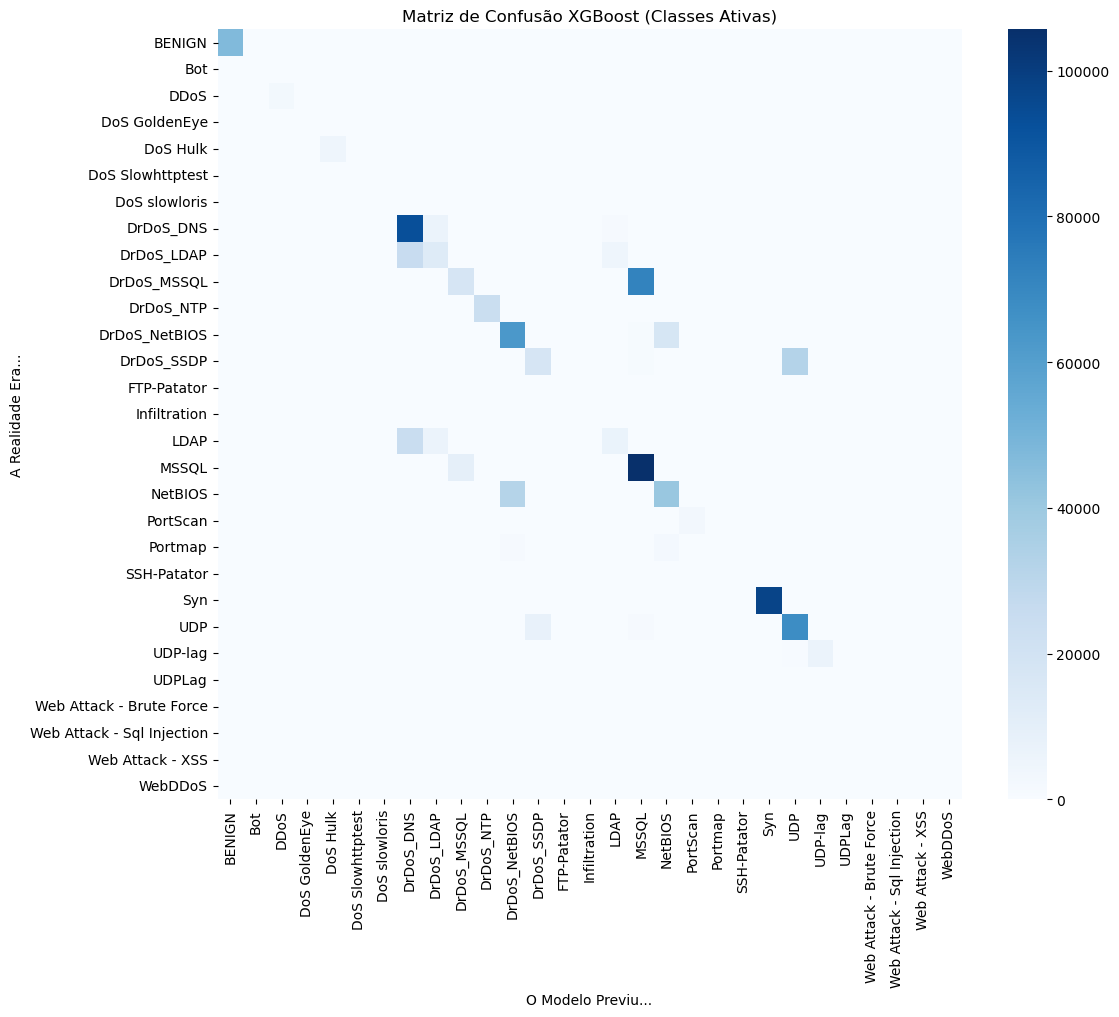

In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(">>> GERANDO RELATÓRIO CORRIGIDO <<<")

# 1. Identifica quais classes realmente existem nos dados de Teste
# (Ignora aquela classe raríssima que só caiu no Treino)
labels_presentes = np.unique(np.concatenate((y_test, y_pred)))
nomes_presentes = [le.classes_[i] for i in labels_presentes]

print(f"📊 Classes Totais no Projeto: {len(le.classes_)}")
print(f"📉 Classes Presentes no Teste: {len(labels_presentes)}")

# 2. Gera o relatório filtrando apenas o que existe
print("\n📋 RELATÓRIO DE DESEMPENHO:")
print(classification_report(y_test, y_pred, labels=labels_presentes, target_names=nomes_presentes))

# 3. Matriz de Confusão (Replotando)
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred, labels=labels_presentes)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=nomes_presentes, yticklabels=nomes_presentes)
plt.title("Matriz de Confusão XGBoost (Classes Ativas)")
plt.xlabel("O Modelo Previu...")
plt.ylabel("A Realidade Era...")
plt.xticks(rotation=90)
plt.show()

>>> AVALIAÇÃO BINÁRIA (DEFESA CIBERNÉTICA) <<<
🛡️ Acurácia de Defesa (Binária): 99.99%
🎯 Precisão (Se bloqueou, era ataque?): 99.99%
🕵️ Recall (Pegou todos os ataques?): 99.99%


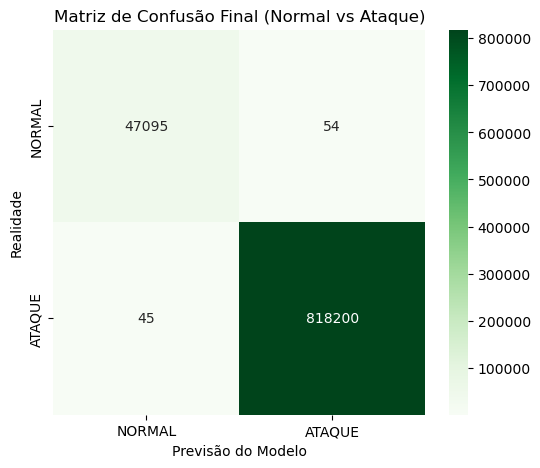

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print(">>> AVALIAÇÃO BINÁRIA (DEFESA CIBERNÉTICA) <<<")

# 1. Converter números de volta para nomes para podermos agrupar
nomes_reais = le.inverse_transform(y_test)
nomes_preditos = le.inverse_transform(y_pred)

# 2. Transformar tudo que NÃO for 'BENIGN' em 'ATAQUE'
binario_real = ['NORMAL' if x == 'BENIGN' else 'ATAQUE' for x in nomes_reais]
binario_pred = ['NORMAL' if x == 'BENIGN' else 'ATAQUE' for x in nomes_preditos]

# 3. Calcular métricas
acuracia_bin = accuracy_score(binario_real, binario_pred)
precisao_bin = precision_score(binario_real, binario_pred, pos_label='ATAQUE')
recall_bin = recall_score(binario_real, binario_pred, pos_label='ATAQUE')

print(f"🛡️ Acurácia de Defesa (Binária): {acuracia_bin*100:.2f}%")
print(f"🎯 Precisão (Se bloqueou, era ataque?): {precisao_bin*100:.2f}%")
print(f"🕵️ Recall (Pegou todos os ataques?): {recall_bin*100:.2f}%")

# Matriz de Confusão Simplificada
cm_bin = confusion_matrix(binario_real, binario_pred, labels=['NORMAL', 'ATAQUE'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Greens', xticklabels=['NORMAL', 'ATAQUE'], yticklabels=['NORMAL', 'ATAQUE'])
plt.title("Matriz de Confusão Final (Normal vs Ataque)")
plt.ylabel("Realidade")
plt.xlabel("Previsão do Modelo")
plt.show()